In [1]:
# Import thư viện cần thiết
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Đọc dữ liệu CYGNSS và thiết lập ranh giới Lâm Đồng
file_path = 'cyg.ddmi.s20220101-030000-e20220101-210000.l3.grid-soil-moisture-9km.a32.d33.nc'
ds = xr.open_dataset(file_path)

# Đọc shapefile Lâm Đồng với pyogrio engine
shapefile_path = '../../../Data/Shapefile/lamdong.shp'
try:
    lamdong_shp = gpd.read_file(shapefile_path, engine='pyogrio')
    print(f"✓ Đã đọc shapefile với pyogrio: {shapefile_path}")
except:
    # Fallback về fiona
    try:
        import fiona
        # Đọc trực tiếp với fiona cũ
        with fiona.open(shapefile_path) as src:
            import pandas as pd
            from shapely.geometry import shape
            records = []
            for record in src:
                records.append({
                    'geometry': shape(record['geometry']),
                    **record['properties']
                })
            lamdong_shp = gpd.GeoDataFrame(records)
        print(f"✓ Đã đọc shapefile với fiona: {shapefile_path}")
    except Exception as e:
        print(f"❌ Lỗi đọc shapefile: {e}")
        raise

# Lấy ranh giới từ shapefile
bounds = lamdong_shp.total_bounds  # [minx, miny, maxx, maxy]
lamdong_bounds = {
    'lat_min': bounds[1],  # miny
    'lat_max': bounds[3],  # maxy
    'lon_min': bounds[0],  # minx
    'lon_max': bounds[2]   # maxx
}

print(f"✓ Ranh giới từ shapefile: {bounds}")
print(f"✓ Đã đọc file CYGNSS: {file_path}")
print(f"Kích thước dataset: {ds.nbytes / (1024*1024):.1f} MB")
print(f"Các biến có sẵn: {list(ds.data_vars.keys())}")
print(f"Ranh giới Lâm Đồng: Lat {lamdong_bounds['lat_min']:.3f}-{lamdong_bounds['lat_max']:.3f}°, Lon {lamdong_bounds['lon_min']:.3f}-{lamdong_bounds['lon_max']:.3f}°")

✓ Đã đọc shapefile với pyogrio: ../../../Data/Shapefile/lamdong.shp
✓ Ranh giới từ shapefile: [107.20617563  10.48328066 108.96955129  12.812495  ]
✓ Đã đọc file CYGNSS: cyg.ddmi.s20220101-030000-e20220101-210000.l3.grid-soil-moisture-9km.a32.d33.nc
Kích thước dataset: 147.3 MB
Các biến có sẵn: ['SM_daily', 'SM_subdaily', 'SIGMA_daily', 'SIGMA_subdaily', 'timeintervals']
Ranh giới Lâm Đồng: Lat 10.483-12.812°, Lon 107.206-108.970°


In [3]:
# Lấy dữ liệu độ ẩm đất cho khu vực Lâm Đồng
# Sử dụng SM_daily (độ ẩm đất hàng ngày)
soil_moisture = ds['SM_daily'].squeeze('time')  # Loại bỏ dimension thời gian

# Cắt dữ liệu theo ranh giới Lâm Đồng
lat_mask = (soil_moisture.lat >= lamdong_bounds['lat_min']) & (soil_moisture.lat <= lamdong_bounds['lat_max'])
lon_mask = (soil_moisture.lon >= lamdong_bounds['lon_min']) & (soil_moisture.lon <= lamdong_bounds['lon_max'])
lamdong_sm = soil_moisture.where(lat_mask & lon_mask, drop=True)

print(f"✓ Đã cắt dữ liệu cho khu vực Lâm Đồng")
print(f"Ranh giới: Lat {lamdong_bounds['lat_min']}-{lamdong_bounds['lat_max']}°, Lon {lamdong_bounds['lon_min']}-{lamdong_bounds['lon_max']}°")
print(f"Kích thước: {lamdong_sm.shape}")
print(f"Số điểm dữ liệu hợp lệ: {lamdong_sm.count().values}")

✓ Đã cắt dữ liệu cho khu vực Lâm Đồng
Ranh giới: Lat 10.483280662000027-12.81249500000007°, Lon 107.20617562600006-108.96955129400004°
Kích thước: (2, 1)
Số điểm dữ liệu hợp lệ: 0


In [4]:
# Loại bỏ giá trị thiếu và thống kê cơ bản
valid_data = lamdong_sm.where(~np.isnan(lamdong_sm))

if valid_data.count() > 0:
    print("=== THỐNG KÊ DỮ LIỆU ĐỘ ẨM ĐẤT LÂM ĐỒNG ===")
    print(f"Đơn vị: {lamdong_sm.units}")
    print(f"Giá trị min: {float(valid_data.min()):.4f}")
    print(f"Giá trị max: {float(valid_data.max()):.4f}")
    print(f"Giá trị trung bình: {float(valid_data.mean()):.4f}")
    print(f"Độ lệch chuẩn: {float(valid_data.std()):.4f}")
    print(f"Tỷ lệ phủ sóng: {float(valid_data.count() / valid_data.size * 100):.1f}%")
else:
    print("⚠️ Không có dữ liệu hợp lệ cho khu vực Lâm Đồng")

⚠️ Không có dữ liệu hợp lệ cho khu vực Lâm Đồng


In [5]:
# Visualization với shapefile overlay
if valid_data.count() > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bản đồ độ ẩm đất với ranh giới shapefile
    valid_data.plot(ax=ax1, cmap='Blues', cbar_kwargs={'shrink': 0.8})
    
    # Vẽ ranh giới Lâm Đồng từ shapefile
    lamdong_shp.boundary.plot(ax=ax1, color='red', linewidth=2, label='Ranh giới Lâm Đồng')
    
    ax1.set_title('CYGNSS Soil Moisture - Lâm Đồng')
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Histogram
    flat_data = valid_data.values.flatten()
    flat_data = flat_data[~np.isnan(flat_data)]
    ax2.hist(flat_data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Soil Moisture (cm³/cm³)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Phân phối độ ẩm đất')
    ax2.grid(True, alpha=0.3)
    
    # Thêm thống kê
    mean_val = np.mean(flat_data)
    ax2.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.4f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Đã tạo visualization với shapefile Lâm Đồng")

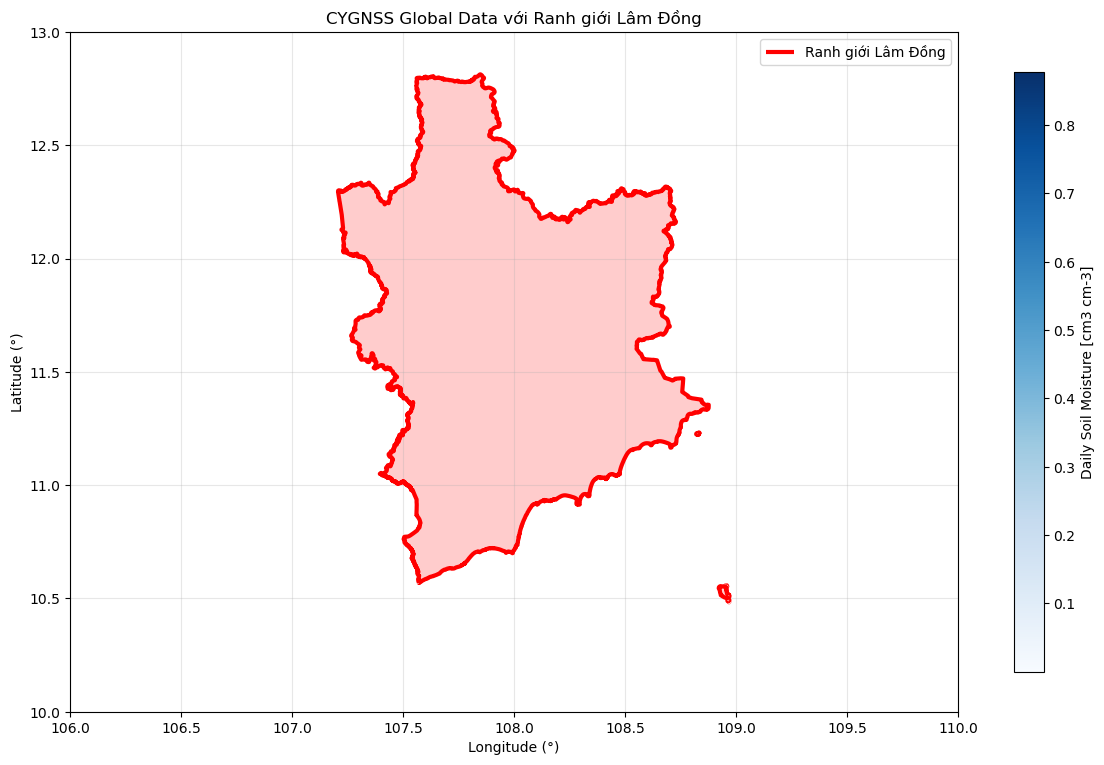

✓ Đã tạo visualization với shapefile Lâm Đồng
📊 Ranh giới Lâm Đồng: {'lat_min': np.float64(10.483280662000027), 'lat_max': np.float64(12.81249500000007), 'lon_min': np.float64(107.20617562600006), 'lon_max': np.float64(108.96955129400004)}
🌍 Data CYGNSS có thể không phủ khu vực này vào ngày ['2022-01-01T12:00:00.000000000']


In [6]:
# Visualization toàn bộ dữ liệu CYGNSS với shapefile overlay
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot toàn bộ dữ liệu CYGNSS
soil_moisture_full = ds['SM_daily'].squeeze('time')
soil_moisture_full.plot(ax=ax, cmap='Blues', cbar_kwargs={'shrink': 0.8})

# Overlay shapefile Lâm Đồng
lamdong_shp.boundary.plot(ax=ax, color='red', linewidth=3, label='Ranh giới Lâm Đồng')
lamdong_shp.plot(ax=ax, color='red', alpha=0.2)

ax.set_title('CYGNSS Global Data với Ranh giới Lâm Đồng')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoom vào khu vực Lâm Đồng
ax.set_xlim(106, 110)
ax.set_ylim(10, 13)

plt.tight_layout()
plt.show()

print(f"✓ Đã tạo visualization với shapefile Lâm Đồng")
print(f"📊 Ranh giới Lâm Đồng: {lamdong_bounds}")
print(f"🌍 Data CYGNSS có thể không phủ khu vực này vào ngày {ds.time.values}")

In [7]:
# Lưu dữ liệu đã xử lý cho tích hợp
if valid_data.count() > 0:
    # Thêm metadata chi tiết
    valid_data.attrs.update({
        'source': 'CYGNSS GNSS-R',
        'region': 'Lam Dong, Vietnam',
        'processing': 'Cropped using shapefile and cleaned for integration',
        'boundary_method': 'shapefile',
        'bounds': f"Lat: {lamdong_bounds['lat_min']:.4f}-{lamdong_bounds['lat_max']:.4f}, Lon: {lamdong_bounds['lon_min']:.4f}-{lamdong_bounds['lon_max']:.4f}",
        'shapefile_used': '../../../Data/Shapefile/lamdong.shp',
        'date': '2022-01-01',
        'crs': 'EPSG:4326'
    })
    
    # Lưu file
    output_file = 'cygnss_lamdong_processed.nc'
    valid_data.to_netcdf(output_file)
    
    print(f"✓ Đã lưu dữ liệu vào: {output_file}")
    print(f"📊 Dữ liệu đã được cắt cho khu vực Lâm Đồng bằng shapefile")
    print(f"🗺️ Sẵn sàng cho tích hợp với SMAP, Sentinel, CHIRPS, DEM")
else:
    print("❌ Không thể lưu do thiếu dữ liệu")

❌ Không thể lưu do thiếu dữ liệu
